# Análisis por Período

#### Condiciones Iniciales:
 - Los Relevamientos se obtienen en varios csv
 - Debido al tiempo que se requiere para correr el scrapping puede que haya dos fechas para el mismo período (ponemos a correr el scrapper el 28 a la noche y termina el 29 a la mañana)
 - Los datos se guardan en una carpeta nombrada como le fecha del relevamiento (Ej: 20180928)
 - Internamente se guardan diversos csv que provienen de la estructura de scrapping que tenemos, todos cnon la misma estructura
 
#### Objetivo:

Un notebook que, a partir de fecha_inicio y fecha_fin, lea las carpetas de dicha fecha, levante los csv y realice comparativas de precios desde el inicio del periodo al fin del mismo.

#### Parámetros

In [1]:
fecha_inicio_relevamiento = "20180420" # Las fecha debe coincidir con nombres de carpetas
fecha_fin_relevamiento = "20180928" # Las fecha debe coincidir con nombres de carpetas

provincia_relevamiento = "AR-X" # Córdoba

sup_titulo_relevamiento = "Precios Mayo/Septiembre '18"
titulo_relevamiento = "Relevamiento del Programa Precios Claros hecho por @opendatacba, para la provincia de Córdoba."


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)

In [3]:
def obtener_path_archivos_de_precios(fecha):
    """Funcion para obtener el listado de archivos csv que almacenan los precios para el relevamiento
    hecho en la fecha pasada por parámetro"""
    
    files_to_read = []
    root_precios = os.path.join(".","datasets","precios", fecha)
    for root, dirs, files in os.walk(root_precios):
        for fname in files:
            files_to_read.append(os.path.join(root, fname))
            
    return(files_to_read)

In [4]:
def obtener_dataset_relevamiento(fecha, inicio_periodo):
    """Funcion que lee la carpeta correspondiente y devuelve un dataframe 
    conteniendo los datos del producto, del establecimiento relevado, el precio
    relevado y la fecha del relevamiento"""
        
    path_archivos_datos = obtener_path_archivos_de_precios(fecha)
    columnas_a_leer = ["fecha_relevamiento", "precio", "producto_id", "sucursal_id"]

    precios = pd.concat((pd.read_csv(f, low_memory=False, usecols=columnas_a_leer, parse_dates=[0]) for f in path_archivos_datos))

    precios = precios[precios["precio"].notnull()]

    # Piso la fecha en la cual se ejecuto el scrapper por la fecha del relevamiento (ver consideraciones)
    precios["fecha_relevamiento"] = pd.to_datetime(fecha)
    
    if inicio_periodo:
        precios.rename({"fecha_relevamiento":"fecha_relevamiento_inicio_periodo","precio": "precio_inicio_periodo"}, axis="columns", inplace=True)
    else:
        precios.rename({"fecha_relevamiento":"fecha_relevamiento_fin_periodo","precio": "precio_fin_periodo"}, axis="columns", inplace=True)   
    
    return(precios)

## Armar dataset comparativo para el Período

#### Cargar datasets de precios y comparar periodos

In [5]:
df_inicio = obtener_dataset_relevamiento(fecha_inicio_relevamiento, inicio_periodo=True)
df_fin = obtener_dataset_relevamiento(fecha_fin_relevamiento, inicio_periodo=False)

df_precios = df_inicio.merge(df_fin, left_on=["producto_id", "sucursal_id"], right_on=["producto_id", "sucursal_id"])
df_precios = df_precios[["producto_id", "sucursal_id", "precio_inicio_periodo", "precio_fin_periodo"]]
df_precios["variacion_periodo"] = round((df_precios["precio_fin_periodo"] / df_precios["precio_inicio_periodo"]) - 1,2)

#### Merge con datasets de Productos

In [6]:
productos = pd.read_csv("./datasets/productos.csv")
productos = productos.drop_duplicates() # El csv tiene muchos duplicados
df_precios = df_precios.merge(productos, left_on="producto_id", right_on="id")

df_precios["nombre"] = df_precios["nombre"].astype("category")
df_precios["marca"] = df_precios["marca"].astype("category")
df_precios["presentacion"] = df_precios["presentacion"].astype("category")
df_precios.drop("id", axis="columns", inplace=True)

#### Merge con datasets de Sucursales y filtrar por Córdoba

In [7]:
sucursales = pd.read_csv("./datasets/sucursales.csv")
sucursales = sucursales[sucursales.provincia == provincia_relevamiento]
sucursales['sucursal_id'] = sucursales.apply(lambda x: f"{x['comercioId']}-{x['banderaId']}-{x['sucursalId']}", axis=1)

cadenas = pd.read_csv('./datasets/cadenas.csv', usecols=['comercioId', 'banderaId', 'comercioRazonSocial', 'banderaDescripcion'])
cadenas.rename(dict(zip(cadenas.columns[-2:], ['empresa', 'cadena'])), inplace=True, axis="columns")
sucursales = pd.merge(sucursales, cadenas, on=['comercioId', 'banderaId'])
sucursales.drop(['provincia', 'sucursalId', 'comercioId', 'banderaId', "lat", "lng"], axis="columns", inplace=True)
sucursales.head()

df_precios = df_precios.merge(sucursales)

#### Inspeccion final

In [8]:
df_precios.head()

,producto_id,sucursal_id,precio_inicio_periodo,precio_fin_periodo,variacion_periodo,nombre,marca,presentacion,localidad,sucursalNombre,direccion,sucursalTipo,empresa,cadena
0,7790080065107,16-1-202,24.99,29.49,0.18,Yogur Entero Firme Frutado Multinutrientes San...,YOGS,180.0 gr,Capital,Hipermercado Jacinto Rios,Libertad 1100,Hipermercado,Libertad S.A,Hipermercado Libertad
1,7790080065183,16-1-202,21.49,24.49,0.14,Yogur Entero Firme Frutilla Sancor Yogs Pack 2...,YOGS,250.0 gr,Capital,Hipermercado Jacinto Rios,Libertad 1100,Hipermercado,Libertad S.A,Hipermercado Libertad
2,7791337651227,16-1-202,17.19,28.00,0.63,Yogur Entero Firme Frutilla Yogurisimo 190 Gr,YOGURISIMO,190.0 gr,Capital,Hipermercado Jacinto Rios,Libertad 1100,Hipermercado,Libertad S.A,Hipermercado Libertad
3,7791337690820,16-1-202,40.00,45.91,0.15,Yogur Entero Firme Frutilla Yogurisimo 4 Un 50...,YOGURISIMO,500.0 gr,Capital,Hipermercado Jacinto Rios,Libertad 1100,Hipermercado,Libertad S.A,Hipermercado Libertad
4,7790080065190,16-1-202,21.49,24.49,0.14,Yogur Entero Firme Vainilla Sancor Yogs Pack 2...,YOGS,250.0 gr,Capital,Hipermercado Jacinto Rios,Libertad 1100,Hipermercado,Libertad S.A,Hipermercado Libertad


### Analisis

In [9]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)

In [10]:
# Si queremos leer desde el csv limpio
# columnas_categoricas = ['producto_id', 'sucursal_id', 'nombre', 'marca', 'presentacion', 'localidad', 'sucursalTipo', 'empresa', 'cadena']
# tipo_columnas = ['category'] * len(columnas_categoricas)
# col_types = dict(zip(columnas_categoricas, tipo_columnas))
# df_precios = pd.read_csv("./datasets/analisis/cordoba_mes_de_septiembre.csv", low_memory=False, dtype=col_types)

In [11]:
# Sacamos outliers
# df_precios = df_precios[(df_precios.variacion_periodo > -0.20) & (df_precios.variacion_periodo < 0.30)]

In [12]:
df_precios.variacion_periodo.describe()

count    84496.000000
mean         0.309342
std          0.238693
min         -0.970000
25%          0.170000
50%          0.290000
75%          0.420000
max          3.060000
Name: variacion_periodo, dtype: float64

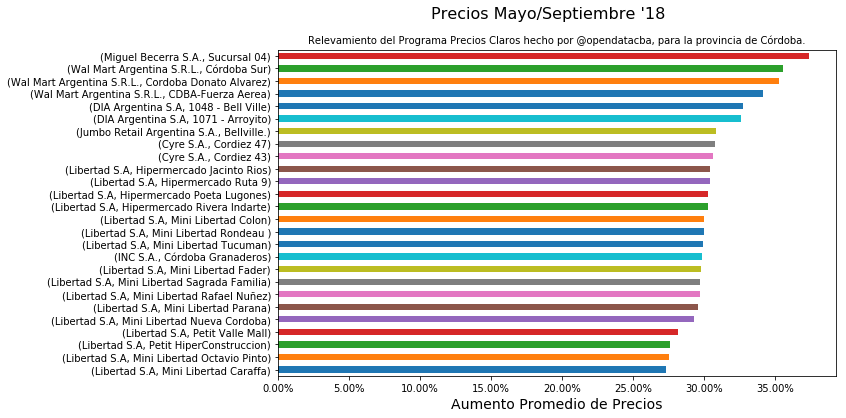

In [13]:
ax = df_precios.groupby(["empresa","sucursalNombre"])["variacion_periodo"].mean().sort_values().plot(kind="barh")
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
plt.suptitle(sup_titulo_relevamiento, size=16)
plt.title(titulo_relevamiento, size=10)
plt.ylabel("")
plt.xlabel("Aumento Promedio de Precios", size=14)
plt.show()

In [14]:
df_precios.groupby(["empresa","sucursalNombre"])["variacion_periodo"].mean().sort_values(ascending=False)

empresa                      sucursalNombre               
Miguel Becerra S.A.          Sucursal 04                      0.374071
Wal Mart Argentina S.R.L.    Córdoba Sur                      0.355653
                             Cordoba Donato Alvarez           0.352456
                             CDBA-Fuerza Aerea                0.341231
DIA Argentina S.A            1048 - Bell Ville                0.327338
                             1071 - Arroyito                  0.326068
Jumbo Retail Argentina S.A.  Bellville.                       0.308074
Cyre S.A.                    Cordiez 47                       0.307393
                             Cordiez 43                       0.306522
Libertad S.A                 Hipermercado Jacinto Rios        0.304286
                             Hipermercado Ruta 9              0.303994
                             Hipermercado Poeta Lugones       0.302934
                             Hipermercado Rivera Indarte      0.302667
                  

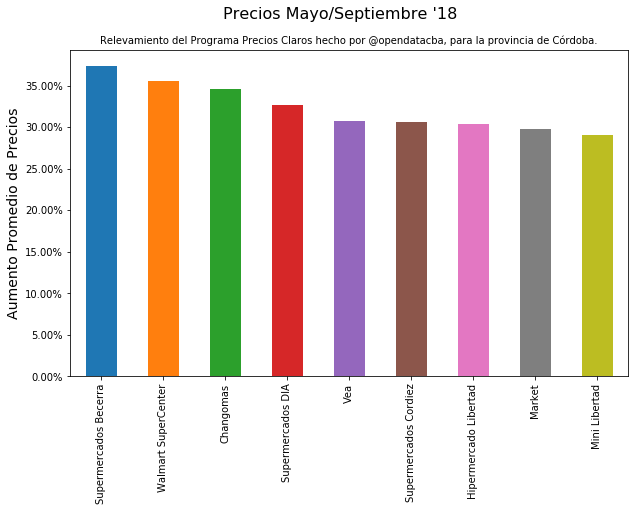

In [15]:
ax = df_precios.groupby(["cadena"])["variacion_periodo"].mean().sort_values(ascending=False).plot(kind="bar")
plt.suptitle(sup_titulo_relevamiento, size=16)
plt.title(titulo_relevamiento, size=10)
plt.xlabel("")
plt.ylabel("Aumento Promedio de Precios", size=14)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

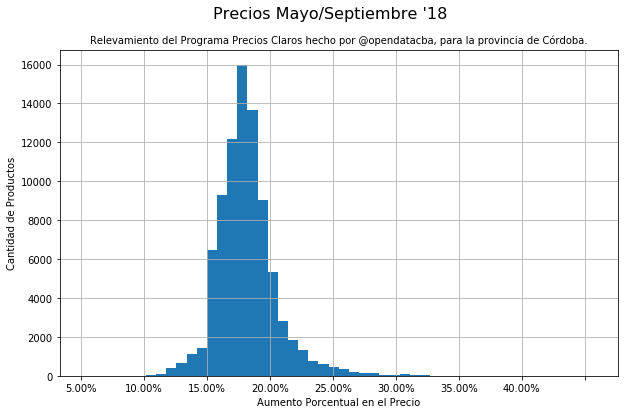

In [16]:
ax = df_precios.variacion_periodo.hist(bins=50)
plt.suptitle(sup_titulo_relevamiento, size=16)
plt.title(titulo_relevamiento, size=10)
plt.ylabel("Cantidad de Productos")
plt.xlabel("Aumento Porcentual en el Precio")
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

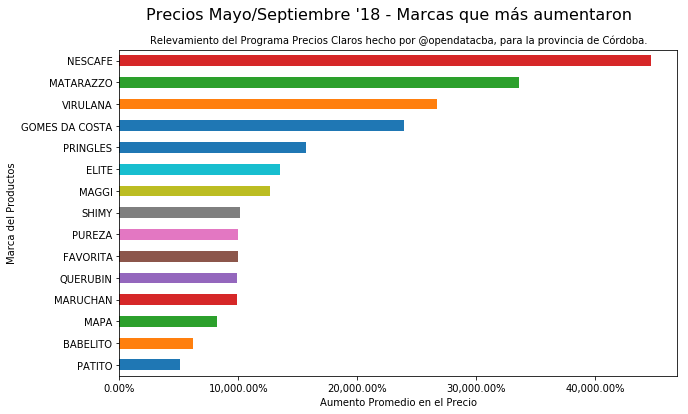

In [17]:
aumentos_marcas = df_precios.groupby("marca")["variacion_periodo"].agg({"mean", "count"}).sort_values(ascending=False, by="mean")
# Nos aseguramos que haya suficientes precios relevados como para que sea representativo el promedio
aumentos_marcas = aumentos_marcas[aumentos_marcas["count"] > 50]
aumentos_marcas.columns = ["aumento_promedio", "cantidad_precios_relevados"]

ax = aumentos_marcas.aumento_promedio.head(15).sort_values().plot(kind="barh")
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
plt.suptitle(sup_titulo_relevamiento + " - Marcas que más aumentaron", size=16)
plt.title(titulo_relevamiento, size=10)
plt.ylabel("Marca del Productos")
plt.xlabel("Aumento Promedio en el Precio")
plt.show()

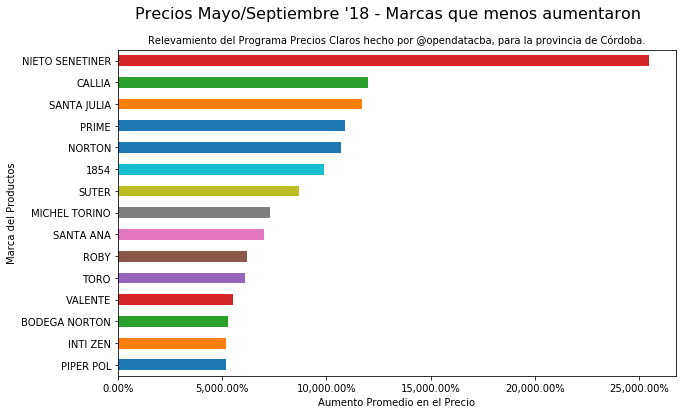

In [18]:
ax = aumentos_marcas.aumento_promedio.tail(15).sort_values().plot(kind="barh")
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
plt.suptitle(sup_titulo_relevamiento + " - Marcas que menos aumentaron", size=16)
plt.title(titulo_relevamiento, size=10)
plt.ylabel("Marca del Productos")
plt.xlabel("Aumento Promedio en el Precio")
plt.show()

## Analisis Productos

In [19]:
def graficar_variacion_producto(df_producto, sup_title_producto):
    ax = df_producto["mean"].plot(kind="barh")
    vals = ax.get_xticks()
    ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
    plt.suptitle(sup_titulo_relevamiento + " - " + sup_title_producto, size=16)
    plt.title(titulo_relevamiento, size=10)
    plt.ylabel("")
    plt.xlabel("Aumento Promedio en el Precio", size=12)
    plt.show()

### Análisis Harinas

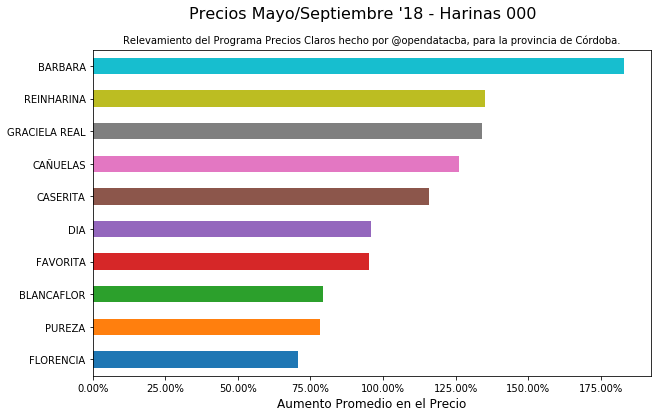

In [20]:
df_harinas = df_precios[df_precios.nombre.str.contains("Harina de Trigo 000")] \
    .groupby("marca", observed=True)["variacion_periodo"] \
    .agg({"mean","count"})\
    .sort_values(by="mean")

graficar_variacion_producto(df_harinas, "Harinas 000")

### Relevamiento Fideos

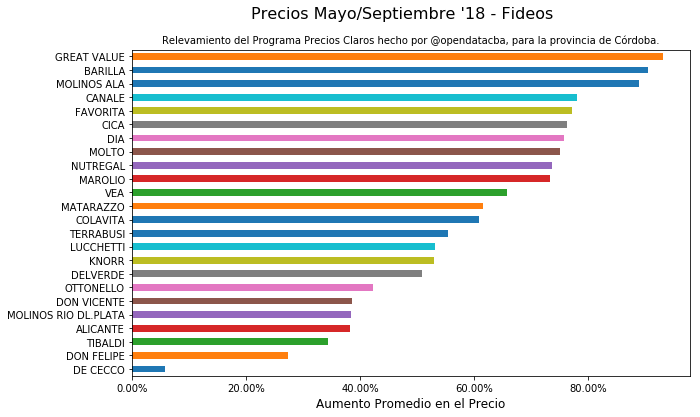

In [21]:
df_fideos = df_precios[df_precios.nombre.str.contains("Fideos")] \
    .groupby("marca", observed=True)["variacion_periodo"] \
    .agg({"mean","count"})\
    .sort_values(by="mean")

df_fideos = df_fideos[df_fideos["count"] > 10]

graficar_variacion_producto(df_fideos, "Fideos")

### Relevamiento Aceite

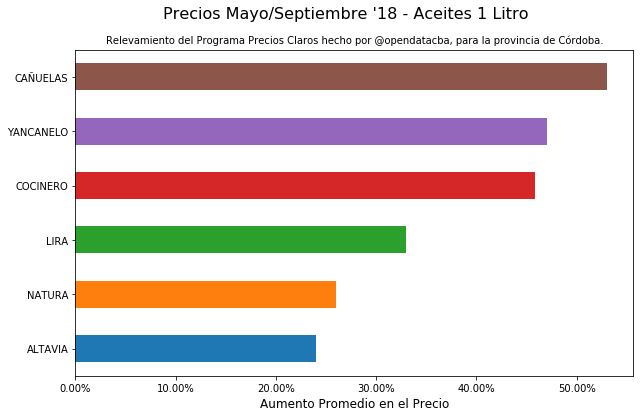

In [22]:
mask_aceites = df_precios.nombre.str.contains("Aceite")
mask_presentacion = df_precios.presentacion.str.contains("1.0 lt")

df_aceites = df_precios[mask_aceites & mask_presentacion] \
    .groupby("marca", observed=True)["variacion_periodo"] \
    .agg({"mean","count"})\
    .sort_values(by="mean")

graficar_variacion_producto(df_aceites, "Aceites 1 Litro")

### Relevamiento Azúcar

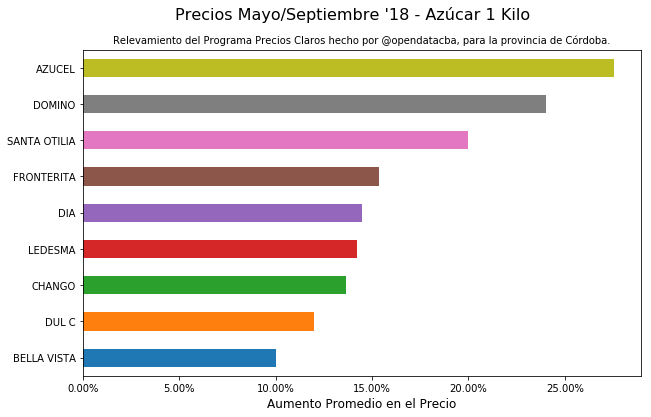

In [23]:
mask_azucar = df_precios.nombre.str.contains("^Azucar")
mask_presentacion_azucar = df_precios.presentacion.str.contains("1.0 kg")

df_azucar = df_precios[mask_azucar & mask_presentacion_azucar] \
    .groupby("marca", observed=True)["variacion_periodo"] \
    .agg({"mean","count"})\
    .sort_values(by="mean")
    
graficar_variacion_producto(df_azucar, "Azúcar 1 Kilo")

### Relevamiento Yerba

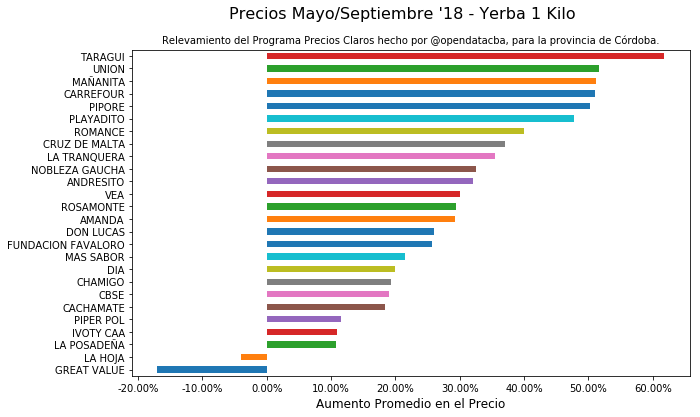

In [24]:
mask_azucar = df_precios.nombre.str.contains("^Yerba")
mask_presentacion_azucar = df_precios.presentacion.str.contains("1.0 kg")

df_yerba = df_precios[mask_azucar & mask_presentacion_azucar] \
    .groupby("marca", observed=True)["variacion_periodo"] \
    .agg({"mean","count"})\
    .sort_values(by="mean")
    
graficar_variacion_producto(df_yerba, "Yerba 1 Kilo")

### Relevamiento Leche

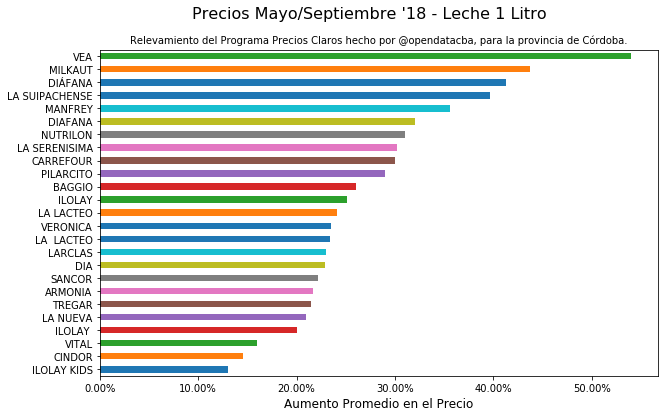

In [25]:
mask_leche = df_precios.nombre.str.contains("^Leche")
mask_presentacion_leche = df_precios.presentacion.str.contains("1.0 lt")

df_leche = df_precios[mask_leche & mask_presentacion_leche] \
    .groupby("marca", observed=True)["variacion_periodo"] \
    .agg({"mean","count"})\
    .sort_values(by="mean")
    
graficar_variacion_producto(df_leche, "Leche 1 Litro")

### Relevamiento Arroz

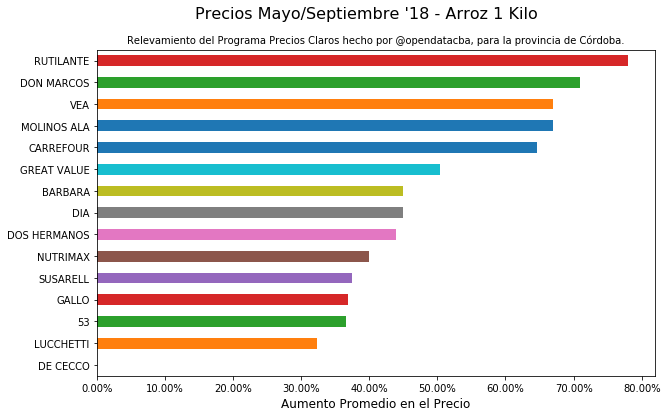

In [26]:
mask_arroz = df_precios.nombre.str.contains("^Arroz")
mask_presentacion_arroz = df_precios.presentacion.str.contains("1.0 kg")

df_arroz = df_precios[mask_arroz & mask_presentacion_arroz] \
    .groupby("marca", observed=True)["variacion_periodo"] \
    .agg({"mean","count"})\
    .sort_values(by="mean")
    
graficar_variacion_producto(df_arroz, "Arroz 1 Kilo")

### Relevamiento Fernet

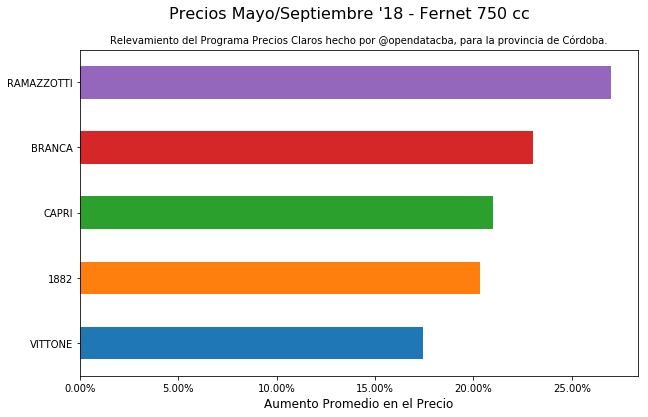

In [27]:
mask_fernet = df_precios.nombre.str.contains("^Fernet")
mask_presentacion_fernet = df_precios.presentacion.str.contains("750.0 cc")

df_fernet = df_precios[mask_fernet & mask_presentacion_fernet] \
    .groupby("marca", observed=True)["variacion_periodo"] \
    .agg({"mean","count"})\
    .sort_values(by="mean")
    
graficar_variacion_producto(df_fernet, "Fernet 750 cc")

## Tabla Comparativa Aumento Productos

In [28]:
df_harinas["producto"] = "Harinas"
df_aceites["producto"] = "Aceites"
df_fideos["producto"] = "Fideos"
df_azucar["producto"] = "Azucar"
df_yerba["producto"] = "Yerba"
df_leche["producto"] = "Leche"
df_arroz["producto"] = "Arroz"
df_fernet["producto"] = "Fernet"

df_productos = pd.concat([df_harinas, df_aceites, df_fideos, df_azucar, df_yerba, df_leche, df_arroz, df_fernet])

df_productos.groupby("producto")["mean"].agg({"mean", "min", "max"}).sort_values(by="mean", ascending=False)

,min,mean,max
producto,,,
Harinas,0.706667,1.113928,1.830000
Fideos,0.058235,0.594888,0.932143
Arroz,0.000000,0.476796,0.780000
Aceites,0.240000,0.381333,0.530000
Yerba,-0.170000,0.285123,0.618030
Leche,0.130000,0.273717,0.540000
Fernet,0.174286,0.217546,0.270000
Azucar,0.100000,0.168088,0.275556
